# Déneigeuse théorie

In [8]:
import numpy as np
import networkx as nx

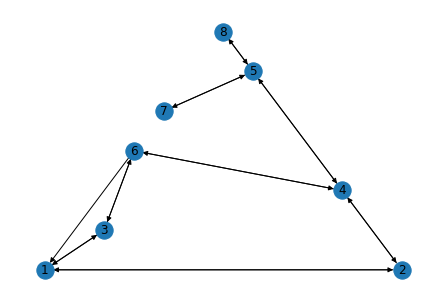

In [9]:
#%matplotlib inline

g = nx.DiGraph()
g.add_nodes_from(range(1, 9))
g.add_edges_from([(1, 2), (7, 5), (6, 1), (6, 4), (6, 3), (3, 1), (8, 5), (5, 4), (4, 2), (2, 1), (1, 3), (2, 4), (3, 6), (4, 5), (4, 6), (5, 7), (5, 8)])

nx.draw_planar(g, with_labels=True)

Dans ce notebook nous allons expliquer le fonctionnement de notre algorithme sur un exemple d'un petit graphe. Ce gaphe est oriente et peut represeneter un arrondissement de Montreal. En effet, notre graphe est connexe car tout comme dans un arrondissement, on peut acceder de tout point A a tout point B. Les arretes du graphe peuvent etre vues comme les routes, elles sont soit a sens unique soit a double sens.

### Comment trouver le chemin le plus rapide ?

La premiere methode qui nous est venu a l'esprit etait de construire un parcours eulerien. Notre graphe etant oriente et n'etant pas forcement eulerien, l'algorithme du parcours eulerien necessite quelques modifications:

1. Premierement on transforme le graphe en un graphe oriente. Les arretes a double sens vont se transformer en double arretes.

2. Ensuite on transforme notre graphe en un graphe eulerien en ajoutant des arretes necessaires

3. On calcule le chemin eulerien

4. La derniere etape consiste a reconstruire notre chemin sur le graphe oriente de depart. Donc lorsqu'on va tomber sur des arretes inexistantes nous allons juste les remplacer par les nouveaux plus courts chemins qu'on trouve.